# Feature Analysis

**RankEval** provides feature analysis tools that allow to estimate the **feature importance** of a trained tree-based ensemble. This analysis can be used for feature selection to improve the estimators’ efficiency on very high-dimensional datasets. The general premise is that features can be either irrelevant or redundant, and thus they can be removed from the dataset without incurring in much loss of information.

A benefit of using gradient boosting algorithms consisting of a number of binary decision trees is that it is relatively straightforward to compute feature importance scores at training time. Indeed, each decision tree is described by multiple nodes, either split or leaf nodes. Every split node is a condition on a single feature, and it is designed to split the dataset into two so that similar response values end up in the same set. Computing feature importance is thus as simple as to sum for each decision tree the amount that each split node (i.e., the feature used by the split node) improves a given performance measure. The performance measure most commonly adopted is the Gini index (purity) used to select the next split nodes at training time.

RankEval implement the calculation of feature importance by *simulating* the traditional training behaviour at scoring time, i.e., with the model already fully trained. To this regard RankEval allows to compute feature importance independently of the framework used to train the model, providing insightful also for frameworks that do not support feature analysis. Moreover, the calculation of feature importance is parametric in the performance measure, allowing for fine-grained and personalized analysis.

In [1]:
# set package autoreload and inline plot

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Import RankEval statistical significance tools

In [2]:
# import libraries
import numpy as np

from rankeval.model import RTEnsemble
from rankeval.dataset import Dataset
from rankeval.analysis.feature import feature_importance
from rankeval.visualization.feature import plot_feature_importance
from rankeval.dataset.datasets_fetcher import load_dataset

## Load Dataset using the `load_dataset` feature

In [3]:
# Dataset container
dataset_container = load_dataset(dataset_name='msn10k', 
                                 fold='1', 
                                 download_if_missing=True, 
                                 force_download=False, 
                                 with_models=False)

Loading files. This may take a few minutes.
done loading dataset!


In [4]:
# Remapping Datasets Names

msn_train = dataset_container.train_dataset
msn_validation = dataset_container.validation_dataset
msn_test = dataset_container.test_dataset

## Train LightGBM model with All Features

Create a metric for computing the performance of the model

In [5]:
from rankeval.metrics import NDCG

ndcg_10 = NDCG(cutoff=10, no_relevant_results=0.5, implementation='exp')

In [15]:
import lightgbm
import os

def lightGBM_algo(trees, leaves, dataset):

    query_len = np.diff(dataset.query_ids)
    lgbm_dataset = lightgbm.Dataset(data=dataset.X, label=dataset.y, group=query_len)
    
    # specify parameters via map 
    params = {'num_leaves': leaves, 
              'objective':'lambdarank',
              'learning_rate': 0.01,
              'use_missing': False}

    lgbm_model = lightgbm.train(params, lgbm_dataset, num_boost_round=trees)
    
    filename = 'lgbm.model'
    rankeval_model = None
    try:
        lgbm_model.save_model(filename=filename)
        rankeval_model = RTEnsemble(filename, name="LightGBM model", format="LightGBM")
    finally:
        os.remove(filename)
    
    return rankeval_model

Train LightGBM model with all features

In [24]:
msn_lgbm_lmart_1Ktrees_model = lightGBM_algo(trees=1000,
                                             leaves=32,
                                             dataset=msn_train)

LightGBM model using all features has a metric score of:

In [25]:
y_pred = msn_lgbm_lmart_1Ktrees_model.score(msn_train)
print "%s: %.3f" % (ndcg_10, ndcg_10.eval(msn_train, y_pred)[0])

NDCG@10: 0.495


### Compute Feature Analysis

The `feature_importance` analysis is executed on a single dataset and model, using a given metric for computing the performance gain at each split node. By default the analysis uses MSE as performance measure (and only in this case the analysis is very efficient since it is realized using low-level cython code). The function returns a xarray.DataArray with the value of `feature_importance` and `feature_count` (the former summing performance gain related to a given feature, the latter counting the number of times a feature is used in a split node) for each feature.

In [26]:
from rankeval.analysis.feature import feature_importance
from rankeval.metrics import MSE

# Create the metric to use as performance measure
mse = MSE()

feature_analysis = feature_importance(model=msn_lgbm_lmart_1Ktrees_model, 
                                      dataset=msn_train, 
                                      metric=mse)
feature_analysis.T.to_dataframe()

Feature Importance Analysis
feature type                                   
0       importance                     0.000012
        count                         40.000000
1       importance                     0.000272
        count                         84.000000
2       importance                     0.000740
        count                        373.000000
3       importance                     0.000018
        count                          7.000000
4       importance                     0.000010
        count                         18.000000
5       importance                     0.000046
        count                        104.000000
6       importance                     0.000396
        count                         88.000000
7       importance                     0.000170
        count                        248.000000
8       importance                     0.000036
        count                         57.000000
9       importance                     0.000046
        count                         48.000000
10      importance                     0.001021
        count                        850.000000
11      importance                     0.000357
        count                        139.000000
12      importance                     0.000728
        count                        193.000000
13      importance                     0.002690
        count                       1335.000000
14      importance                     0.004862
        count                        882.000000
...                                         ...
121     importance                     0.000312
        count                        187.000000
122     importance                     0.012714
        count                        304.000000
123     importance                     0.001327
        count                        162.000000
124     importance                     0.000383
        count                        193.000000
125     importance                     0.002108
        count                        845.000000
126     importance                     0.002376
        count                       1349.000000
127     importance                     0.001497
        count                        843.000000
128     importance                     0.005861
        count                       1791.000000
129     importance                     0.004005
        count                       1678.000000
130     importance                     0.002885
        count                       1100.000000
131     importance                     0.000690
        count                        374.000000
132     importance                     0.002688
        count                       1841.000000
133     importance                     0.020894
        count                        959.000000
134     importance                     0.002972
        count                       1284.000000
135     importance                     0.000500
        count                        482.000000

[272 rows x 1 columns]

RankEval provides also a utility for directly plotting the result of the feature analysis in order to have a visual representation of the importance of each feature. The method `plot_feature_importance` takes in input the analysis executed above, as well as the number of top-k features to plot and how to sort the features (by importance gain or by gain). Moreover, it is possible to pass a list of feature names to use in place on feature index in the plot.

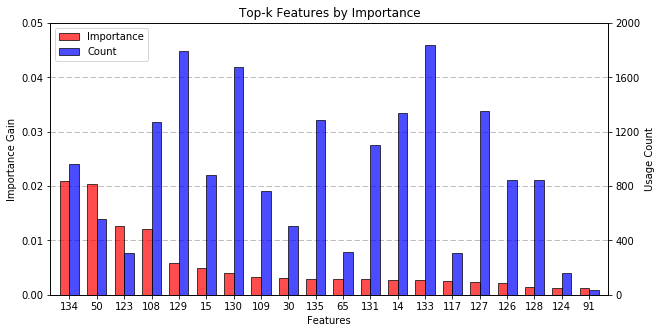

In [27]:
from rankeval.visualization.feature import plot_feature_importance

fig = plot_feature_importance(feature_analysis, max_features=20, sort_by='gain')

## Train LightGBM model by using only Top-20 Features out of 136

In [34]:
sorted_features = np.argsort(feature_analysis.sel(type='importance').values)[::-1]
top_features = sorted_features[:20]

msn_train_filtered = msn_train.subset_features(top_features)

msn_lgbm_lmart_1Ktrees_top20f_model = lightGBM_algo(trees=1000, 
                                                    leaves=32, 
                                                    dataset=msn_train_filtered)

LightGBM model using top 20 features only has a metric score of:

In [35]:
y_pred = msn_lgbm_lmart_1Ktrees_top20f_model.score(msn_train_filtered)
print "%s: %.3f" % (ndcg_10, ndcg_10.eval(msn_train_filtered, y_pred)[0])

NDCG@10: 0.486


Compared to the performance of the model using all features (0.495) it performs slightly worser but using only 15% of the features.